## Preface

This post is something of a departure from the focus of this blog - exploring the use of data science and machine learning to improve investment decision-making. However, every person reading this has been living through a (hopefully) once-in-a-lifetime pandemic so I think this departure is warranted. 

## Motivation

As a data geek, I've tried to make sense of this frightening, fascinating, frustrating era in our lives at least partially through data. Not many days have passed in the past 18 months without checking some sort of COVID statistics - case rates, positivity rates, transmission rates, vaccinations, and so forth. Early in the pandemic, many great data dashboards popped up - from the Washington Post, NY Times, and others. 

However, innovation in this department seems to have stagnated and I'm often not able to find empirical answers to important questions. Like many a data geek, I've become an armchair epidemiologist (a subject I had barely given a thought to prior to Feb 2020) so I'd like to roll my own dashboard of state-by-state COVID data to explore some questions. 

In this post, I will use familiar python tools to create a jupyter notebook based dashboard. Along the way, I'll cover some basic patterns used to interface with REST APIs, plotting functions, and simple linear regressions. All of these are very relevant to data-science-driven finance so it's actually a very small departure for the blog. If you find this interesting and worthwhile, please take a moment to post a comment below with what you found interesting and what would be of interest in the future. 

I'm making a version of this notebook available on Google's great Colab platform so you can get your hands on the examples with an absolute minimum of setup. Scroll to the bottom for the access link.

## COVID Data API

I'm going to make use of the excellent API maintained by [COVID Act Now](https://covidactnow.org/about), a great non-profit that came into existence in March 2020 to gather and distribute COVID data from states, counties, and municipalities in a consistent and convenient manner. I suspect that many of the websites you've used to monitor COVID statistics make use of this API to do what they do. Please take a minute to [donate]() to this group if you have a few coins to spare...

The API is free to use, but requires that you register for an API key and jot down a few words about what you're doing with the data. Out of respect for the organization, I won't share my API key here, so please take a second to register [here](https://apidocs.covidactnow.org/#register) for a key. 

Below, we'll go through the data in much more detail, but at a high level [this is the sort of data](https://apidocs.covidactnow.org/data-definitions) offered by the API. Current and historical data of these types are available for different geographies (United States overall, states, counties, and CBSAs).

Let's get to it. 


## Setup and Imports
Below are the imports which will be required. You will also need to get the aforementioned API key [here](https://apidocs.covidactnow.org/#register) and assign the `API_KEY` variable

In [5]:
import requests
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.express as px
from pprint import pprint
import json

API_KEY = ''


In [6]:
import plotly.offline as pyo
pyo.init_notebook_mode() #may be necessary to avoid this problem: https://stackoverflow.com/questions/52771328/plotly-chart-not-showing-in-jupyter-notebook

## Using the API

The COVID Act Now API is refreshingly straight-forward. As the documents show, there are a number of endpoints which follow a predictable pattern. An example endpoint looks like this:

`https://api.covidactnow.org/v2/state/FL.json?apiKey=<YOUR_KEY_HERE>`

This endpoint returns current data for a single state (FL) in json format. Data can be downloaded in a csv format by swapping out `.json?` with `.csv?` in the url pattern, however I'm partial to json for this sort of usage because it's easier to navigate, so I'll use that here.

Executing this endpoint with the `requests` module returns an easy to understand json. 

In [7]:
state = 'FL'
url_state_current = f'https://api.covidactnow.org/v2/state/{state}.json?apiKey={API_KEY}'
jsn = requests.get(url_state_current).json()
pprint(jsn)

{'actuals': {'cases': 2951228,
             'contactTracers': 2600,
             'deaths': 41130,
             'hospitalBeds': {'capacity': 76852,
                              'currentUsageCovid': 16841,
                              'currentUsageTotal': 47311,
                              'typicalUsageRate': 0.76},
             'icuBeds': {'capacity': 6811,
                         'currentUsageCovid': 3590,
                         'currentUsageTotal': 6244,
                         'typicalUsageRate': 0.76},
             'negativeTests': 30807330,
             'newCases': 21669,
             'newDeaths': 7,
             'positiveTests': 3391791,
             'vaccinationsCompleted': 10863504,
             'vaccinationsInitiated': 13209116,
             'vaccinationsInitiatedDemographics': {'age': {'12-14': 91571,
                                                           '15-24': 774834,
                                                           '25-34': 983521,
                  

Since the structure of this json is new to me, I'll take a look at its structure with a tool like this: 


In [8]:
print(jsn.keys())
print()
print(jsn['actuals'].keys())
print()
print(jsn['metrics'].keys())

dict_keys(['fips', 'country', 'state', 'county', 'level', 'lat', 'locationId', 'long', 'population', 'metrics', 'riskLevels', 'cdcTransmissionLevel', 'actuals', 'annotations', 'lastUpdatedDate', 'url'])

dict_keys(['cases', 'deaths', 'positiveTests', 'negativeTests', 'contactTracers', 'hospitalBeds', 'icuBeds', 'newCases', 'newDeaths', 'vaccinesDistributed', 'vaccinationsInitiated', 'vaccinationsCompleted', 'vaccinesAdministered', 'vaccinesAdministeredDemographics', 'vaccinationsInitiatedDemographics'])

dict_keys(['testPositivityRatio', 'testPositivityRatioDetails', 'caseDensity', 'contactTracerCapacityRatio', 'infectionRate', 'infectionRateCI90', 'icuHeadroomRatio', 'icuHeadroomDetails', 'icuCapacityRatio', 'vaccinationsInitiatedRatio', 'vaccinationsCompletedRatio'])


It appears (and the documentation confirms) that `actuals` contains a collection of "raw facts" (number of deaths, etc...) while `metrics` has a collection of ratios derived from these raw facts. We probably want some of each so will use something like the following to unpack this json into a more easily viewed pandas `DataFrame`. Thankfully the builtin dataframe method `json_normalize()` does a great job of flattening the somewhat messy structure of nested dicts. 

In [9]:
def parse_json_current(jsn):
    s = pd.json_normalize(jsn).iloc[0]
    return s.rename('current')

df = parse_json_current(jsn)
df


fips                                                                                     12
country                                                                                  US
state                                                                                    FL
county                                                                                 None
level                                                                                 state
                                                                ...                        
annotations.icuHeadroomRatio.anomalies                                                   []
annotations.icuCapacityRatio.sources      [{'type': 'other', 'url': 'https://healthdata....
annotations.icuCapacityRatio.anomalies                                                   []
annotations.vaccinationsInitiatedRatio                                                 None
annotations.vaccinationsCompletedRatio                                          

To get and parse a historical timeseries of this same data (which is what we're really after...), the "endpoint" (the url pattern used to get data for a given state) is nearly identical. I will create functions to download any state's history as well as the US as a whole

In [10]:
def download_state(state):
    url_state = f'https://api.covidactnow.org/v2/state/{state}.timeseries.json?apiKey={API_KEY}'
    return requests.get(url_state).json()

def download_us():
    url = f'https://api.covidactnow.org/v2/country/US.timeseries.json?apiKey={API_KEY}'
    return requests.get(url).json()


The parsing required for historical data is a little more complex. The timeseries data is located in three different nested lists: `actualsTimeseries`, `metricsTimeseries`, and `riskLevelsTimeseries`. Each of these needs to be extracted into separate dataframes so they can be merged on common date values. Only a couple of important fields (namely, `state`) need to be added in from non-nested key:value pairs. 

Note that we need to recast the `date` field to be an acutal `datetime`, not just a string that reads like a date. 

In [11]:
def parse_json_historical(jsn):
    # extract all timeseries oriented data
    df_actuals = pd.DataFrame(jsn['actualsTimeseries']).set_index('date')
    df_metrics = pd.DataFrame(jsn['metricsTimeseries']).set_index('date')
    df_risk = pd.DataFrame(jsn['riskLevelsTimeseries']).set_index('date')
    df_risk = df_risk.add_prefix('risk_')

    # join together on date value
    df = pd.concat([df_actuals, df_metrics, df_risk],axis=1).reset_index()
    
    # set the date value to be an actual datetime typed object
    df['date'] = pd.to_datetime(df['date'])
    
    # append necessary metadata not in timeseries
    df['state'] = jsn['state']
    df['population'] = jsn['population']
    return df

jsn = download_state('FL')
df = parse_json_historical(jsn)
df

date      cases   deaths  positiveTests  negativeTests  \
0   2020-01-29        NaN      NaN            NaN            NaN   
1   2020-01-30        NaN      NaN            NaN            NaN   
2   2020-01-31        NaN      NaN            NaN            NaN   
3   2020-02-01        NaN      NaN            NaN            NaN   
4   2020-02-02        NaN      NaN            NaN            NaN   
..         ...        ...      ...            ...            ...   
563 2021-08-14  2873523.0  40766.0      3391373.0     30806423.0   
564 2021-08-15  2873523.0  40766.0      3391791.0     30807330.0   
565 2021-08-16  2929559.0  41123.0            NaN            NaN   
566 2021-08-17  2951228.0  41130.0            NaN            NaN   
567 2021-08-18        NaN      NaN            NaN            NaN   

     contactTracers                                       hospitalBeds  \
0               NaN  {'capacity': None, 'currentUsageTotal': None, ...   
1               NaN  {'capacity': None, 'currentUsageTotal': None, ...   
2               NaN  {'capacity': None, 'currentUsageTotal': None, ...   
3               NaN  {'capacity': None, 'currentUsageTotal': None, ...   
4               NaN  {'capacity': None, 'currentUsageTotal': None, ...   
..              ...                                                ...   
563          2600.0  {'capacity': None, 'currentUsageTotal': 49313,...   
564          2600.0  {'capacity': None, 'currentUsageTotal': 48861,...   
565          2600.0  {'capacity': None, 'currentUsageTotal': 47314,...   
566          2600.0  {'capacity': None, 'currentUsageTotal': 47311,...   
567          2600.0  {'capacity': None, 'currentUsageTotal': None, ...   

                                               icuBeds  newCases  newDeaths  \
0    {'capacity': None, 'currentUsageTotal': None, ...       NaN        NaN   
1    {'capacity': None, 'currentUsageTotal': None, ...       NaN        NaN   
2    {'capacity': None, 'currentUsageTotal': None, ...       NaN        NaN   
3    {'capacity': None, 'currentUsageTotal': None, ...       NaN        NaN   
4    {'capacity': None, 'currentUsageTotal': None, ...       NaN        NaN   
..                                                 ...       ...        ...   
563  {'capacity': 6885, 'currentUsageTotal': 6338, ...     179.0        0.0   
564  {'capacity': 6862, 'currentUsageTotal': 6321, ...       0.0        0.0   
565  {'capacity': 6811, 'currentUsageTotal': 6245, ...   56036.0      357.0   
566  {'capacity': 6811, 'currentUsageTotal': 6244, ...   21669.0        7.0   
567  {'capacity': None, 'currentUsageTotal': None, ...       NaN        NaN   

     ... infectionRate infectionRateCI90  icuHeadroomRatio  icuCapacityRatio  \
0    ...           NaN               NaN               NaN               NaN   
1    ...           NaN               NaN               NaN               NaN   
2    ...           NaN               NaN               NaN               NaN   
3    ...           NaN               NaN               NaN               NaN   
4    ...           NaN               NaN               NaN               NaN   
..   ...           ...               ...               ...               ...   
563  ...          1.13               0.1              0.86              0.92   
564  ...          1.13               0.1              0.87              0.92   
565  ...          1.13               0.1              0.86              0.92   
566  ...          1.13               0.1              0.86              0.92   
567  ...           NaN               NaN               NaN               NaN   

     vaccinationsInitiatedRatio  vaccinationsCompletedRatio  risk_overall  \
0                           NaN                         NaN             0   
1                           NaN                         NaN             0   
2                           NaN                         NaN             0   
3                           NaN                         NaN             0   
4        

## Now, Do Stuff...

With just these steps, we have a well formatted set of data for Florida which we can analyze. A simple `matplotlib` plot of new cases per 100K population (seven day moving average) is as simple as this: 

<AxesSubplot:xlabel='date'>

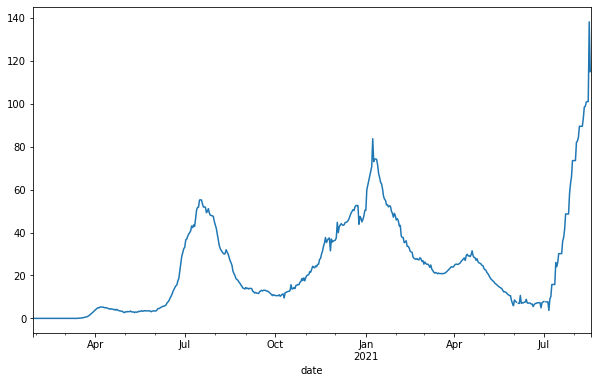

In [12]:
df.set_index('date')['caseDensity'].plot(figsize=(10,6))

I'll generalize and beautify this a bit into a function. I'd also like to specifically highlight times when given states have trended above/below national averages. A single variable for a single state could be compared to the national average like this:

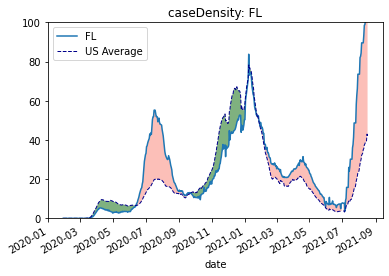

In [13]:
def plot_timeseries(jsn_state, jsn_us, metric, ax=None):
    ''' Plots a given metric for a given state, highlights periods where the state exceeded national averages'''
    
    df = parse_json_historical(jsn_state)
    df_us = parse_json_historical(jsn_us)
    
    # extract the desired metric and put into series
    state = parse_json_historical(jsn_state)['state'].iloc[0] # infer state from data
    a = df.set_index('date')[metric].dropna().rename(state)
    b = df_us.set_index('date')[metric].reindex(a.index).rename('US Average')

    
    # Depending on the metric plotted, higher or lower may be good (green). Also, set the 
    # ylim param to some reasonable (and consistent) range
    param_dict = {'infectionRate':((0,2),'lower'),
         'caseDensity':((0,100),'lower'),
         'icuCapacityRatio':((0,1),'lower'),
         'icuHeadroomRatio':((0,1),'lower'),
         'vaccinationsInitiatedRatio':((0,.75),'higher'),
         'vaccinationsCompletedRatio':((0,.75),'higher'),         
         'testPositivityRatio':((0,0.25),'lower'),
        }    
    default_param = ((None,None),'lower')
    ylim, orientation = param_dict.get(metric, default_param) 
    
    # now draw the plot
    
    ax = a.plot(ylim=ylim, title=f'{metric}: {state}', legend=True, ax=ax)
    b.plot(color='darkblue', ls='--', lw=1, legend=True, ax=ax)

    up_color = 'darkgreen' if orientation == 'higher' else 'salmon'
    down_color = 'salmon' if orientation == 'higher' else 'darkgreen'

    ax.fill_between(a.index, a, b, where=a>b, facecolor=up_color, alpha=0.5)
    ax.fill_between(a.index, a, b, where=a<=b, facecolor=down_color, alpha=0.5)
    
    return

jsn_state = download_state('FL')
jsn_us = download_us()

plot_timeseries(jsn_state, jsn_us,'caseDensity')

With that plotting function created, we can assemble simple dashboards of multiple metrics for a given state, like this: 

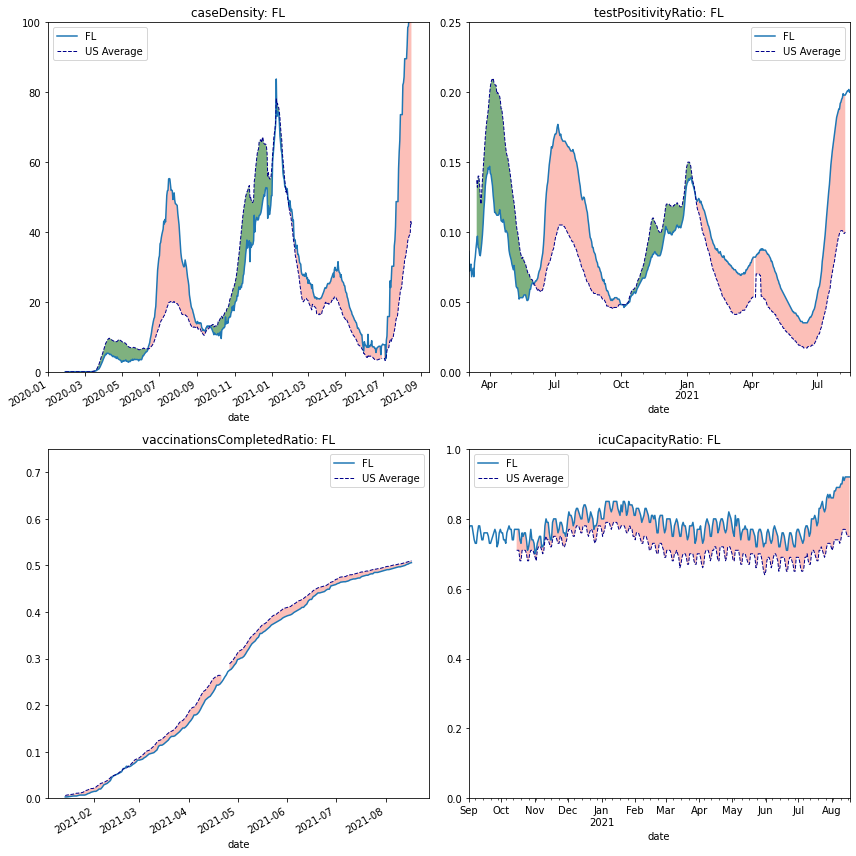

In [14]:
def make_state_dashboard(state, metrics = ['caseDensity','testPositivityRatio','vaccinationsCompletedRatio']):
    jsn_state = download_state(state)
    jsn_us = download_us()
    
    num_metrics = len(metrics)
    num_cols = 2
    num_rows = (num_metrics-1)//num_cols + 1
    
    fig,axs = plt.subplots(num_rows,num_cols, figsize=(num_cols * 6,num_rows * 6), sharex=False)
    
    n = 0
    r,c = 0,0
    for metric in metrics:
        c = n % num_cols
        r = n // num_cols

        if num_rows == 1: # handles cases where we need a single indexer or row and column indexers
            ax = axs[c]
        else: 
            ax = axs[r,c] 
        plot_timeseries(jsn_state, jsn_us,metric,ax=ax)
        n +=1
        
    plt.tight_layout()
    
    return

make_state_dashboard('FL',['caseDensity','testPositivityRatio','vaccinationsCompletedRatio','icuCapacityRatio'])

Or we can compare and contrast multiple states on a single metric. For instance, if I want to test the theory that southern states have generally fared worse during peak "air conditioning months" of June to August, while northern states have had their problems during peak "heating months" of December to February.

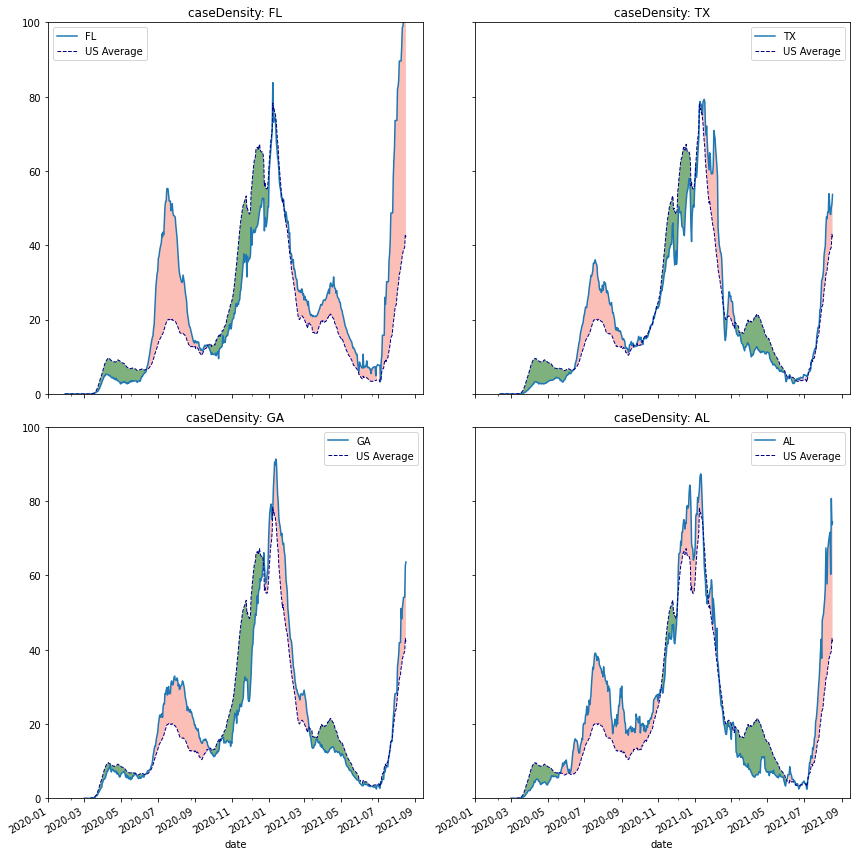

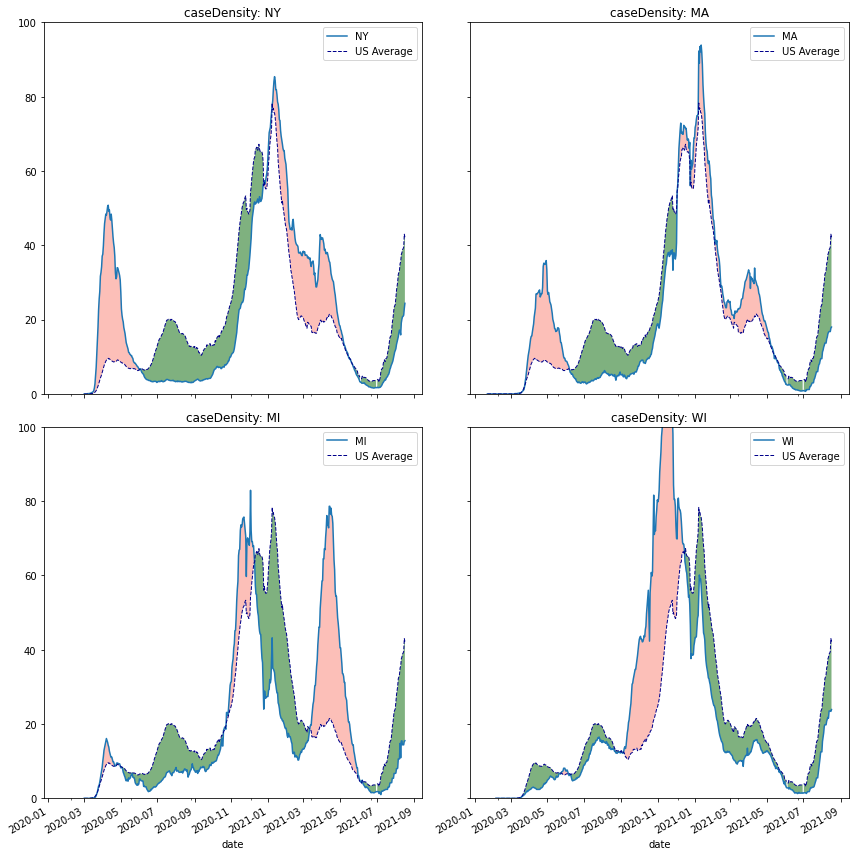

In [15]:
def compare_states(metric, states = ['FL','TN','GA','AL',
                                     'NY','MA','MI','WI']):
    jsn_us = download_us()
    
    num_states = len(states)
    num_cols = 2
    num_rows = (num_states-1)//num_cols + 1
    
    fig,axs = plt.subplots(num_rows,num_cols, figsize=(num_cols * 6,num_rows * 6), sharex=True, sharey=True)
    
    n = 0
    r,c = 0,0
    for state in states:
        jsn_state = download_state(state)
        c = n % num_cols
        r = n // num_cols

        if num_rows == 1: # handles cases where we need a single indexer or row and column indexers
            ax = axs[c]
        else: 
            ax = axs[r,c] 
        plot_timeseries(jsn_state, jsn_us,metric,ax=ax)
        n +=1
        
    plt.tight_layout()
    
    return

hot_states = ['FL','TX','GA','AL']
compare_states('caseDensity',states = hot_states)

cold_states = ['NY','MA','MI','WI']
compare_states('caseDensity',states = cold_states)

It does indeed seem like the warm weather states have been on the wrong side of the averages during summer months while colder weather states have generally had difficulties during the colder weather months. This is not rigorous proof of anything, but interesting nonetheless. 

## What Drives Case Rates? 

Having access to the underlying data allows other, more advanced analyses which may not be available in off-the-shelf dashboards. For instance, I'd like to quantify the relationship between vaccination rates and case rates across states - something which has been much-reported in the news. 

Rather than looping through each of the 50 states with the state-by-state function, there is another endpoint which gets all of the data in one shot. I'll only extract the `metrics` section of the json to keep things simple. I'm also going to grab the population from 

In [16]:
url_all_states_current = f'https://api.covidactnow.org/v2/states.json?apiKey={API_KEY}'
jsn = requests.get(url_all_states_current).json()
df_current = pd.DataFrame([item['metrics'] for item in jsn], index=[item['state'] for item in jsn] )
df_current['population'] = pd.Series([item['population'] for item in jsn], index=[item['state'] for item in jsn] )
df_current.head()

testPositivityRatio testPositivityRatioDetails  caseDensity  \
AK                0.067        {'source': 'other'}         51.1   
AL                0.236        {'source': 'other'}         74.3   
AR                0.116        {'source': 'other'}         70.9   
AZ                0.114        {'source': 'other'}         38.7   
CA                0.067        {'source': 'other'}         31.3   

    contactTracerCapacityRatio  infectionRate  infectionRateCI90  \
AK                        0.13           1.12                0.1   
AL                        0.02           1.13                0.1   
AR                        0.07           1.01                0.1   
AZ                        0.03           1.14                0.1   
CA                        0.17           1.08                0.1   

    icuHeadroomRatio                                 icuHeadroomDetails  \
AK              0.47  {'currentIcuCovid': 27, 'currentIcuCovidMethod...   
AL              0.98  {'currentIcuCovid': 757, 'currentIcuCovidMetho...   
AR              0.69  {'currentIcuCovid': 474, 'currentIcuCovidMetho...   
AZ              0.29  {'currentIcuCovid': 390, 'currentIcuCovidMetho...   
CA              0.50  {'currentIcuCovid': 1704, 'currentIcuCovidMeth...   

    icuCapacityRatio  vaccinationsInitiatedRatio  vaccinationsCompletedRatio  \
AK              0.76                       0.528                       0.463   
AL              0.99                       0.468                       0.357   
AR              0.80                       0.510                       0.388   
AZ              0.57                       0.552                       0.466   
CA              0.77                       0.671                       0.544   

    population  
AK      731545  
AL     4903185  
AR     3017804  
AZ     7278717  
CA    39512223

We could simple `plot.scatter` this in pandas, but since we may want to interact with the chart a bit, I'll construct a simple scatterplot in matplotlib. 

_Note that my preference would be to use the excellent `plotly` package since it supplies mouse-over annotation, but plotly charts aren't rendering correctly in the blog. See the colab notebook for a plotly example_

<AxesSubplot:title={'center':'Current Case Density vs. Vaccination Rates\nState-by-State'}, xlabel='vaccinationsInitiatedRatio', ylabel='caseDensity'>

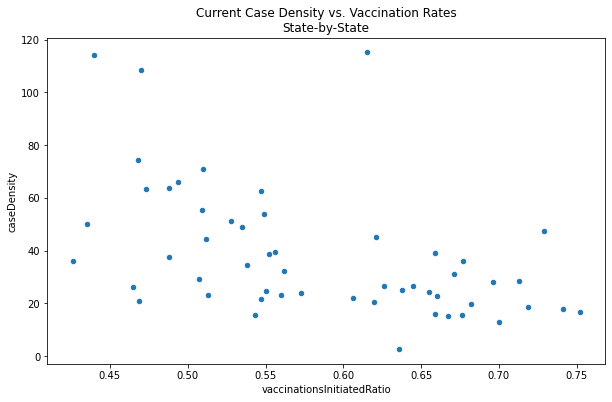

In [26]:
df_current.plot.scatter(x='vaccinationsInitiatedRatio',y='caseDensity', figsize=(10,6),
                       title='Current Case Density vs. Vaccination Rates\nState-by-State')

In [22]:
# px.scatter(x=df_current.vaccinationsInitiatedRatio, y=df_current.caseDensity, 
#            size=df_current.population, hover_name=df_current.index)

It's pretty clear from the prior chart that there is a relationship between vaccination rate and infection rate. We could take this further to evaluate which current factors predict case rates a few weeks down the road. In other words, do current values for metrics like `testPositivityRatio` or `infectionRate` help us to forecast future spikes.

To do this, we will need to get all timeseries data for all states, one at a time. The below loop will do just that. 

_Pro tip: when gathering and concatenating data into a dataframe, it's much cleaner (and faster) to first compile the files to a list and then concat that list only once, rather than concatenating each state's dataframe incrementally (i.e., concatenating 50 times vs once)_

In [18]:
results = []
for state in df_current.index:
    jsn_tmp = download_state(state)
    df_tmp = parse_json_historical(jsn_tmp)
    results.append(df_tmp)

df_all = pd.concat(results,axis=0)

## What Drives Mortality? 
Now that we have the data all together, we can extract both (a) the possible predictive features and (b) the target variable we want to learn to predict, i.e., the future case rate - or change in case rate - by date/state. Using these as input data, we'll build a simple multivariate linear regression model. 

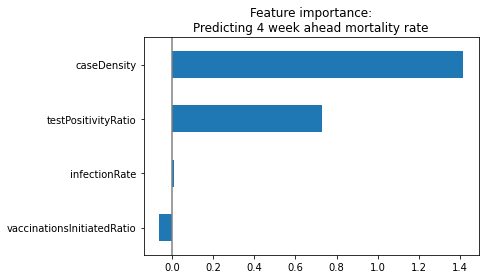

In [19]:
# subset the data to exclude the earliest days of COVID
df_tmp = df_all.set_index(['date','state'])
# df_tmp = df_tmp.xs(slice('2021-01-01',None),level='date',drop_level=False)

# create target data, which is weekly mortality per 100K n weeks in the future
prediction_horizon = 4
y = (df_tmp.newDeaths/df_tmp.population*100000)
y = y.unstack().resample('W-FRI').sum().shift(-prediction_horizon).stack().dropna().rename('mortality_4wk')

# create X features 
X = df_tmp[['caseDensity','infectionRate','testPositivityRatio',
                                    'vaccinationsInitiatedRatio']]

# transform X (features) into Z-scores to make the regression coefficients more interpretable
def z_score(s):
    return (s-s.mean())/s.std()
X_norm = X.apply(z_score)
X_norm.describe()

# exclude any observations where X or y values are missing
Xy = X_norm.join(y)
Xy['vaccinationsInitiatedRatio'] = Xy['vaccinationsInitiatedRatio'].fillna(0)
Xy = Xy.dropna().xs(slice('2021-01-01',None),level='date',drop_level=False)
y = Xy[y.name]
X_norm = Xy.drop(columns=y.name)

# fit a linear regression and evaluate the learned coefficients
model = LinearRegression()
model.fit(X_norm,y)
ax = pd.Series(model.coef_,index=X_norm.columns).sort_values().plot.barh(title=f'Feature importance:\nPredicting {prediction_horizon} week ahead mortality rate')
ax.axvline(x=0, color='grey')

The results are interesting. `caseDensity` is the most significant driver of deaths four weeks in the future, which makes intuitive sense. Interesting to me is that `testPositivityRatio` is a close second as driver of future death. I'm not certain what relationship exists, but I'll guess that states with a very high positivity ratio likely is significantly undercounting the true caseDensity (only the seriously symptomatic are even going in for tests).

For those more inclined to think in terms of p-values and t-stats, we can run a simple statistical summary like this:

In [20]:
import statsmodels.api as sm
sm_model = sm.OLS(y, X_norm.astype(float))
results = sm_model.fit()

print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:          mortality_4wk   R-squared (uncentered):                   0.433
Model:                            OLS   Adj. R-squared (uncentered):              0.432
Method:                 Least Squares   F-statistic:                              295.8
Date:                Wed, 18 Aug 2021   Prob (F-statistic):                   4.57e-189
Time:                        10:31:22   Log-Likelihood:                         -3449.3
No. Observations:                1552   AIC:                                      6907.
Df Residuals:                    1548   BIC:                                      6928.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

Broadening a bit, we can look at how these metrics could predict deaths in time periods other than the somewhat arbitrary 4 week ahead horizon. The below loop repeats the same basic process as above for each lookahead from zero to 10 weeks, capturing the coefficient loadings and plotting them over the range of target horizons. 

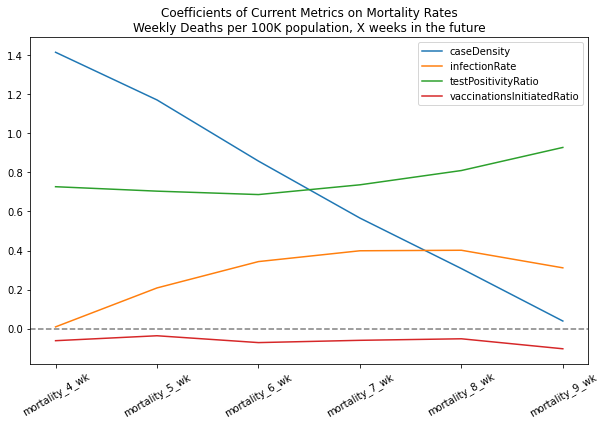

In [21]:

results = []
for lookahead in range(4,10):
    
    y = df_tmp.newDeaths.fillna(0)/(df_tmp.population/100000)
    y = y.unstack().resample('W-FRI').sum().shift(-lookahead).stack().dropna().rename(f'mortality_{lookahead}_wk')

    Xy = X_norm.join(y)
    Xy['vaccinationsInitiatedRatio'] = Xy['vaccinationsInitiatedRatio'].fillna(0) # vax rate was ~zero before it began to be reported
    Xy = Xy.dropna()

    y = Xy[y.name]
    X_norm = Xy.drop(columns=y.name)

    model = LinearRegression()

    model.fit(X_norm,y)
    s = pd.Series(model.coef_,index=X_norm.columns).rename(y.name)
    results.append(s)
    
df_coefs = pd.concat(results,axis=1).T
ax = df_coefs.plot(figsize=(10,6), title='Coefficients of Current Metrics on Mortality Rates\nWeekly Deaths per 100K population, X weeks in the future', rot=30)
ax.axhline(y=0,color='grey',ls='--')

The results are interesting. Current `caseDensity` matters most in the shorter term (i.e., the next 4 to 6 weeks), while today's `infectionRatio` (ie the replication rate R(t) ) begins to become more important a couple of months in the future, as expected with a geometric growth process. My net worth tomorrow will be largely dependent on my net worth today, but my net worth in 50 years will depend to a much greater degree on the rate at which I compounded my assets. 

Perhaps most confounding is that `testPositivityRatio` remains significant across all horizons, which is something I don't (yet) understand. 

## Try it Out!

Enough reading, already! The above code is available on colab at the link below. Feel free to try it out yourself.

<a style="text-align: center;" href="https://colab.research.google.com/drive/1thGrl25AIG1fPn3rCo6NJamgspnZi4Aa?usp=sharing"><img src="images/colab.png" title="ipynb on Colab" /></a>

You can modify the notebook however you'd like without risk of breaking it. I really hope that those interested will "fork" from my notebook (all you'll need is a Google Drive to save a copy of the file...) and extend it to answer your own questions through data. I have several on my mind - and you probably have many others:
- Is there a robust relationship between climate (or weather) and COVID transmission rates? Could [Cooling Degree Days](https://ftp.cpc.ncep.noaa.gov/htdocs/products/analysis_monitoring/cdus/degree_days/archives/Cooling%20Degree%20Days/weekly%20cooling%20degree%20days%20state/) and [Heating Degree Days](https://ftp.cpc.ncep.noaa.gov/htdocs/products/analysis_monitoring/cdus/degree_days/archives/Heating%20degree%20Days/weekly%20states/) be useful in predicting new case transmission rates?
- What is the approximate lead/lag relationship between spikes in positivity rates, case rates, hospitalization rates, ICU rates, and mortality rates? Is this changing over time? 
- What implication does positivity rate have on true case rates (vs. reported rates)? In other words, does a state with a case rate of 25 but positivity rate of 20% behave differently than a state with the same case rate but positivity rate of 5%?
- Is there strong relationship between mobility data - such as the [dataset](https://www.google.com/covid19/mobility/) provided by Google - to case transmission rates?
- Empirically estimate how many new cases are avoided by each additional person vaccinated. Same for mortality.  
- Quantify the strength of autoregressive behavior in `infectionRatio`. In other words, how persistent is this rate of replication? My guess is that it's pretty "sticky"...
- How much deadlier is the "delta variant", based on state-level statistics? I haven't found it but there must be some community monitoring test data out there? 

If readers put together any insights, please consider sharing a link to your colab notebook in the comments below. 


## One last thing...
If you've found this post helpful, please consider subscribing to the email list to be notified of future posts (email addresses will only be used for this purpose...).

You can also follow me on [twitter](https://twitter.com/data2alpha) and forward to a friend or colleague who may find this topic interesting.